In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import talib
import requests
from dotenv import load_dotenv
from datetime import datetime, timedelta, timezone
from zoneinfo import ZoneInfo
from dataclasses import dataclass

from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame


if "google.colab" in sys.modules:
    # In Google Colab environment, we will fetch API keys from Secrets.
    # Please set ALPACA_API_KEY, ALPACA_SECRET_KEY in Google Colab's Secrets from the left sidebar
    from google.colab import userdata

    ALPACA_API_KEY = userdata.get("ALPACA_API_KEY")
    ALPACA_SECRET_KEY = userdata.get("ALPACA_SECRET_KEY")
else:
    # Please safely store your API keys and never commit them to the repository (use .gitignore)
    # Load environment variables from environment file (e.g., .env)
    load_dotenv()
    # API credentials for Alpaca's Trading API and FRED API
    ALPACA_API_KEY = os.environ.get("ALPACA_API_KEY")
    ALPACA_SECRET_KEY = os.environ.get("ALPACA_SECRET_KEY")
    FRED_API_KEY = os.environ.get("FRED_API_KEY")

## We use paper environment for this example
ALPACA_PAPER_TRADE = True

# setup stock historical data client
stock_historical_data_client = StockHistoricalDataClient(ALPACA_API_KEY, ALPACA_SECRET_KEY)

In [2]:
def kelly_fraction(p, b=1.0):
    """Calculates the optimal Kelly fraction."""
    q = 1.0 - p
    return (p * b - q) / b

def expected_log_growth(f, p, b=1.0):
    """Calculates the theoretical expected log growth rate (r)."""
    # Formula: r = p * log(1 + b*f) + q * log(1 - f)
    if f >= 1.0 or f <= -1.0/b:
        return -np.inf # Ruin
    return p * np.log(1 + b * f) + (1 - p) * np.log(1 - f)

# Calculate for our scenario
p_win = 0.55
b_odds = 1.0
optimal_f = kelly_fraction(p_win, b_odds)

print(f"Optimal Bet Size: {optimal_f:.2%}")
# Output: Optimal Bet Size: 10.00%

Optimal Bet Size: 10.00%


In [3]:
# Simulate the scenario (55% win rate, 5,000 simulations over 250 trades) to see what actually happens to our money.
def run_simulation(p=0.55, b=1.0, T=250, N=5000, fractions=None):
    """
    Runs Monte Carlo simulation for Kelly betting strategy.
    
    Parameters:
        p: float - Win probability
        b: float - Odds (payoff ratio)
        T: int - Number of trades per simulation
        N: int - Number of simulations
        fractions: list - Kelly fractions to test
    
    Returns:
        dict: Results for each fraction including wealth paths and ruin probabilities
    """
    if fractions is None: 
        fractions = [0.1]
    
    results = {}
    
    # 1. Generate random outcomes (1=Win, 0=Loss) for all N traders at once
    # seed=42 makes results reproducible but not truly "Monte Carlo"
    rng = np.random.default_rng(42)
    outcomes = rng.random((N, T)) < p

    for f in fractions:
        # 2. Calculate wealth multipliers: (1 + b*f) for win, (1 - f) for loss
        multipliers = np.where(outcomes, 1 + b * f, 1 - f)
        
        # 3. Calculate cumulative wealth path
        cumulative = np.cumprod(multipliers, axis=1)
        wealth_paths = np.column_stack([np.ones(N), cumulative])
        
        # 4. Calculate Key Metrics
        final_wealth = wealth_paths[:, -1]
        log_growth = np.log(final_wealth) / T
        
        # 5. Calculate Risk of Ruin at multiple thresholds
        min_wealth = np.min(wealth_paths, axis=1)
        prob_ruin_50 = np.mean(min_wealth <= 0.50)  # 50% drawdown
        prob_ruin_25 = np.mean(min_wealth <= 0.25)  # 75% drawdown
        prob_ruin_complete = np.mean(min_wealth <= 0.01)  # 99% loss (effective ruin)
        
        results[f] = {
            'wealth_paths': wealth_paths,
            'mean_log_growth': np.mean(log_growth),
            'median_final_wealth': np.median(final_wealth),
            'mean_final_wealth': np.mean(final_wealth),
            'prob_ruin_50': prob_ruin_50,
            'prob_ruin_25': prob_ruin_25,
            'prob_ruin_complete': prob_ruin_complete,
            'min_wealth_overall': np.min(min_wealth)
        }
    
    return results

## Three Important Lessons from Simulation Results

In [4]:
# Configuration
p = 0.55   # 55% Win rate
b = 1.0    # 1:1 Odds
T = 250    # 250 Trades (approx 1 year of daily trading)
N = 5000   # 5000 Simulations

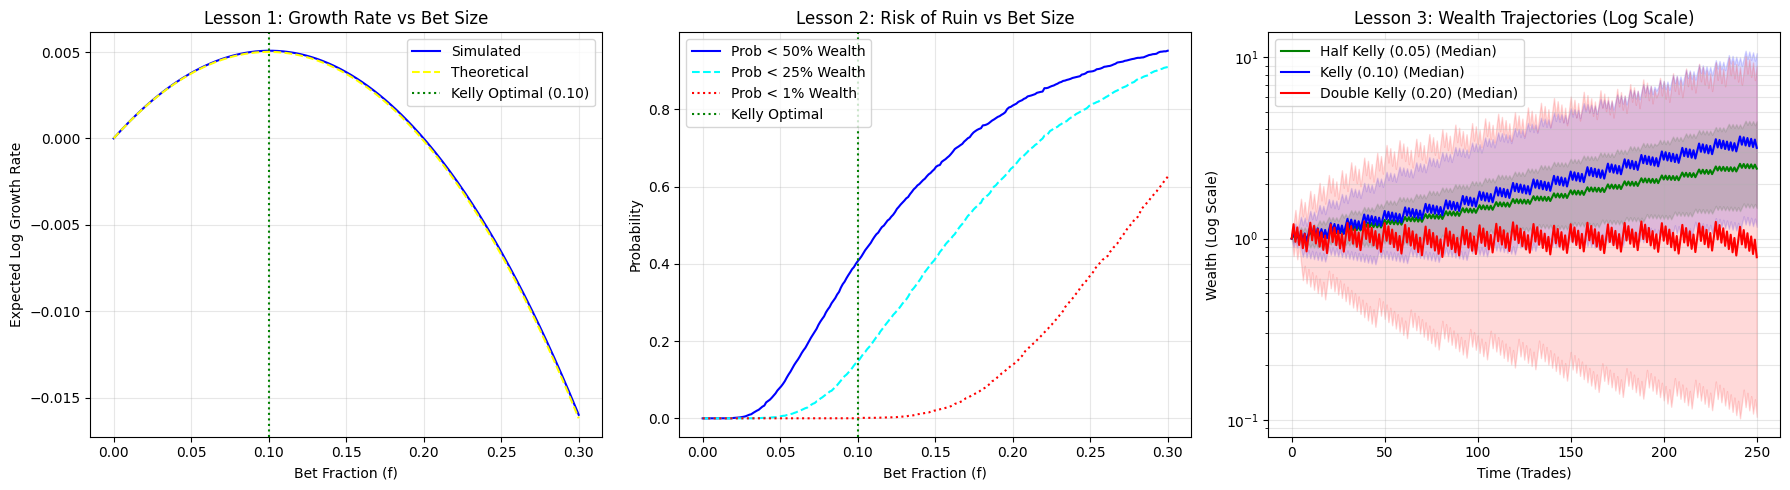

In [5]:
# 1. Theoretical vs Simulated Growth
test_fractions = np.linspace(0.0, 0.3, 250) # 0% to 30% betting
sim_results = run_simulation(p, b, T, N, test_fractions)

# Extract data for plotting
f_values = sorted(sim_results.keys())
growth_sim = [sim_results[f]['mean_log_growth'] for f in f_values]
growth_theory = [expected_log_growth(f, p, b) for f in f_values]
dd_50 = [sim_results[f]['prob_ruin_50'] for f in f_values]
dd_25 = [sim_results[f]['prob_ruin_25'] for f in f_values]
dd_complete = [sim_results[f]['prob_ruin_complete'] for f in f_values]

# 2. Wealth Trajectories for Specific Strategies
strategies = {
    'Half Kelly (0.05)': 0.05,
    'Kelly (0.10)': 0.10,
    'Double Kelly (0.20)': 0.20
}
traj_results = run_simulation(p, b, T, N, list(strategies.values()))

# --- Visualization ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Growth Rate (The Cliff)
axes[0].plot(f_values, growth_sim, label='Simulated', color='blue')
axes[0].plot(f_values, growth_theory, '--', label='Theoretical', color='yellow')
axes[0].axvline(0.10, color='green', linestyle=':', label='Kelly Optimal (0.10)')
axes[0].set_title('Lesson 1: Growth Rate vs Bet Size')
axes[0].set_xlabel('Bet Fraction (f)')
axes[0].set_ylabel('Expected Log Growth Rate')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Drawdown Risk (The Ruin)
axes[1].plot(f_values, dd_50, color='blue', label='Prob < 50% Wealth')
axes[1].plot(f_values, dd_25, color='cyan', linestyle='--', label='Prob < 25% Wealth')
axes[1].plot(f_values, dd_complete, color='red', linestyle=':', label='Prob < 1% Wealth')
axes[1].axvline(0.10, color='green', linestyle=':', label='Kelly Optimal')
axes[1].set_title('Lesson 2: Risk of Ruin vs Bet Size')
axes[1].set_xlabel('Bet Fraction (f)')
axes[1].set_ylabel('Probability')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Wealth Over Time (The Spread)
colors = ['green', 'blue', 'red']
for (name, f), color in zip(strategies.items(), colors):
    paths = traj_results[f]['wealth_paths']
    # Calculate percentiles
    p25 = np.percentile(paths, 25, axis=0)
    p50 = np.percentile(paths, 50, axis=0)
    p75 = np.percentile(paths, 75, axis=0)
    
    x = np.arange(T + 1)
    axes[2].plot(x, p50, color=color, label=f'{name} (Median)')
    axes[2].fill_between(x, p25, p75, color=color, alpha=0.15)

axes[2].set_yscale('log')
axes[2].set_title('Lesson 3: Wealth Trajectories (Log Scale)')
axes[2].set_xlabel('Time (Trades)')
axes[2].set_ylabel('Wealth (Log Scale)')
axes[2].legend()
axes[2].grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

## Kelly driven volatility targeting with hard constraints using excess returns (AAPL, NVDA)

What the code does:
1) Pull daily equity bars for AAPL and NVDA using [alpaca-py (StockHistoricalDataClient)](https://app.alpaca.markets/signup)
2) Pull the 3-month T-bill rate (DTB3) from [FRED using the official API (fred/series/observations)](https://fred.stlouisfed.org/docs/api/fred/)
3) Convert the annualized T-bill yield into a daily risk-free return
4) Compute daily excess returns and annualize mean excess return and volatility
5) Estimate Kelly leverage using the mean–variance approximation  
   L* = mu_excess / sigma^2
6) Map positive Kelly leverage to portfolio weights and apply hard allocation constraints


In [6]:
NY_TZ = ZoneInfo("America/New_York")
today = datetime.now(NY_TZ).date()
# Set the expiration date range
end_time = today - timedelta(hours=1) 
start_time = today - timedelta(days=30)

TRADING_DAYS = 252
SYMBOLS = ["AAPL", "NVDA"]

SERIES_ID = "DTB3"  # daily 3-month T-bill rate (percent)
FRED_URL = "https://api.stlouisfed.org/fred/series/observations"

@dataclass(frozen=True)
class Constraints:
    gross_cap: float = 1.00
    max_weight: float = 0.60
    min_weight: float = 0.00

In [11]:
def fetch_daily_bars_df(
    symbols: list[str],
    start: datetime,
    end: datetime,
) -> pd.DataFrame:
    """
    Fetch daily OHLCV bars for a list of US equity symbols from Alpaca.

    Parameters:
      symbols: List of tickers, such as ["AAPL", "NVDA"].
      start: Start datetime (timezone-aware recommended, UTC preferred).
      end: End datetime (timezone-aware recommended, UTC preferred).

    Returns:
      DataFrame with columns including:
        symbol, timestamp, open, high, low, close, volume
      Sorted by symbol then timestamp.
    """
    req = StockBarsRequest(
        symbol_or_symbols=symbols,
        timeframe=TimeFrame.Day,
        start=start,
        end=end,
    )
    df = stock_historical_data_client.get_stock_bars(req).df.reset_index()
    df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)
    return df.sort_values(["symbol", "timestamp"]).reset_index(drop=True)

In [7]:
def fetch_fred_series(
    series_id: str,
    start_date: str,
    api_key: str,
    base_url: str = FRED_URL,
) -> pd.Series:
    """
    Fetch a FRED time series as a decimal annualized rate series.

    Parameters:
      series_id: FRED series ID, e.g. "DTB3" (3-month T-bill).
      start_date: Observation start date in "YYYY-MM-DD".
      api_key: FRED API key.
      base_url: FRED observations endpoint.

    Returns:
      Pandas Series indexed by UTC date timestamps, values as decimal annual rate.
      Note: Many FRED rate series are expressed as percent per year; this function converts to decimal.
    """
    params = {
        "series_id": series_id,
        "api_key": api_key,
        "file_type": "json",
        "observation_start": start_date,
    }
    r = requests.get(base_url, params=params, timeout=30)
    r.raise_for_status()

    obs = r.json()["observations"]
    df = pd.DataFrame(obs)[["date", "value"]]
    df["date"] = pd.to_datetime(df["date"], utc=True)
    df["value"] = pd.to_numeric(df["value"], errors="coerce")
    df = df.dropna().set_index("date").sort_index()

    # Most rate series are percent per year -> decimal annual rate
    return (df["value"] / 100.0).rename(series_id)

In [8]:
def annual_to_daily(
    annual_rate: np.ndarray,
    trading_days: int,
) -> np.ndarray:
    """
    Convert annualized rate (decimal) to an approximate daily return via compounding.

    Parameters:
      annual_rate: Array of annualized rates in decimal form (e.g. 0.05 for 5%).
      trading_days: Number of trading days per year, commonly 252.

    Returns:
      Array of daily returns aligned to annual_rate.
    """
    annual_rate = np.asarray(annual_rate, dtype=float)
    return (1.0 + annual_rate) ** (1.0 / trading_days) - 1.0


def kelly_stats(
    prices: np.ndarray,
    rf_annual: np.ndarray,
    trading_days: int,
) -> tuple[float, float, float]:
    """
    Compute mean-variance Kelly inputs and Kelly leverage for a single asset.

    Parameters:
      prices: Array of close prices (length N).
      rf_annual: Array of annualized risk-free rates aligned to returns (length N-1).
      trading_days: Number of trading days per year.

    Returns:
      mu_excess_annual: Annualized mean excess return.
      sigma_annual: Annualized volatility of raw returns.
      L_star: Kelly leverage approximation L* = mu / sigma^2.
    """
    prices = np.asarray(prices, dtype=float)
    rets = prices[1:] / prices[:-1] - 1.0

    rf_annual = np.asarray(rf_annual, dtype=float)
    rf_daily = annual_to_daily(rf_annual, trading_days)

    excess = rets - rf_daily
    mu_excess_annual = float(excess.mean()) * trading_days
    sigma_annual = float(rets.std(ddof=1)) * np.sqrt(trading_days)

    L_star = mu_excess_annual / (sigma_annual ** 2) if sigma_annual > 0 else 0.0
    return mu_excess_annual, sigma_annual, float(L_star)

In [9]:
def kelly_vol_target(
    symbols: list[str],
    start_time: datetime,
    end_time: datetime,
    series_id: str = "DTB3",
    trading_days: int = 252,
    lookback_days: int = 252,
    max_weight: float = 0.70,
    gross_cap: float = 1.00,
    fred_api_key: str = FRED_API_KEY,
) -> pd.DataFrame:
    """
    Compute Kelly-driven volatility targeting allocations with hard constraints.

    Parameters:
      symbols: List of symbols to analyze.
      start_time: Start datetime for market data (timezone-aware, UTC preferred).
      end_time: End datetime for market data (timezone-aware, UTC preferred).
      series_id: FRED series ID used as risk-free proxy (default "DTB3").
      trading_days: Trading days per year used for annualization (default 252).
      lookback_days: Number of daily returns used per symbol (default 252).
      max_weight: Hard cap per symbol weight (long-only).
      gross_cap: Cap on total long exposure (sum of weights).
      fred_api_key: FRED API key string.

    Returns:
      DataFrame indexed by symbol with:
        mu_excess (annual), sigma (annual), kelly_L, weight
    """
    bars = fetch_daily_bars_df(symbols, start_time, end_time)

    # Pull risk-free series with a small buffer for forward-filling
    rf = fetch_fred_series(
        series_id=series_id,
        start_date=(start_time - timedelta(days=30)).strftime("%Y-%m-%d"),
        api_key=fred_api_key,
    )

    rows = []
    for sym in symbols:
        # Extract recent close prices for the symbol
        px = bars.loc[bars["symbol"] == sym, ["timestamp", "close"]].tail(lookback_days + 1)
        if px.shape[0] < lookback_days + 1:
            raise ValueError(f"Not enough bars for {sym}. Need {lookback_days + 1}, got {px.shape[0]}.")

        dates = px["timestamp"].iloc[1:].dt.floor("D")
        rf_aligned = rf.reindex(dates).ffill().to_numpy(dtype=float)

        mu, sigma, L = kelly_stats(px["close"].to_numpy(dtype=float), rf_aligned, trading_days,)
        rows.append({"symbol": sym, "mu_excess": mu, "sigma": sigma, "kelly_L": L})

    stats = pd.DataFrame(rows).set_index("symbol")

    # Allocation (hard constraints)
    desire = stats["kelly_L"].clip(lower=0.0)
    weights = desire / desire.sum() if float(desire.sum()) > 0 else desire
    weights = weights.clip(upper=max_weight)

    if float(weights.sum()) > gross_cap and float(weights.sum()) > 0:
        weights *= gross_cap / float(weights.sum())

    stats["weight"] = weights
    return stats

In [12]:
if __name__ == "__main__":
    result = kelly_vol_target(
        symbols=["AAPL", "NVDA"],
        start_time=datetime(2023, 1, 1, tzinfo=timezone.utc),
        end_time=datetime(2024, 12, 31, tzinfo=timezone.utc),
        series_id="DTB3",
    )
    print(result.round(4))

        mu_excess   sigma  kelly_L  weight
symbol                                    
AAPL       0.2417  0.2268   4.6990  0.7000
NVDA       0.2035  1.0449   0.1864  0.0381
